# Quadrupole Potential

Loading the quadrupole potential generated in ANSYS.

In [1]:
import numpy as np

rfp = open('potentialQuadrupole.fld', 'r')
tmp = rfp.read()
tmp = tmp.split('\n')[2:-1]
tmp = [[float(tis) for tis in ti.split()] for ti in tmp]

x = np.array([row[0] for row in tmp])
y = np.array([row[1] for row in tmp])
z = np.array([row[2] for row in tmp])
V = np.array([row[3] for row in tmp])

Masking all values at $r>2.2$cm with `nan` in the potential

In [2]:
mask = (np.sqrt(x**2+y**2) > 0.022)
V[mask] = np.nan

Function generating grid coordinates from Ansys simulation coordinates

In [3]:
def create_grid_potential(x,y,z,data):
    x_vals, x_idx = np.unique(x, return_inverse=True)
    y_vals, y_idx = np.unique(y, return_inverse=True)
    z_vals, z_idx = np.unique(z, return_inverse=True)

    datax_grid = np.empty([max(x_vals.shape), max(y_vals.shape), max(z_vals.shape)])
    datax_grid.fill(np.nan)
    datax_grid[x_idx,y_idx,z_idx] = data
    return (x_vals, y_vals, z_vals), datax_grid

Creating the grid potential

In [4]:
(x_vals, y_vals, z_vals), pot_vals = create_grid_potential(x,y,z,V)

Function finds the nearest value in the array and returns the index

In [5]:
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

Generating 2D polyfit of potential in the center of the quadrupole; found in `Loading Trajectories, Velocities and Fields; Generating Interpolating functions.ipynb` that a 3D polynomial wasn't accurate enough, so using a 2D polynomial for xy of the quadrupole potential, and a 1d interpolating function (`UnivariateSpline`) to get the potential along the quadrupole at the location of one of the quadrupole electrodes

In [73]:
idx = find_nearest(x_vals, np.sqrt(0.0219**2/2))
idy = find_nearest(y_vals, np.sqrt(0.0219**2/2))

maskz = z_vals > 0
f = np.abs(pot_vals[idx, idy, :].flatten())[maskz]
f -= f.min()
f /= f.max()

l = maskz.sum()
z_spliced = np.zeros(l*2)
ind_sort = np.argsort(-z_vals[maskz])
z_spliced[:l] = -z_vals[maskz][ind_sort]
z_spliced[-l:] = z_vals[maskz]
f_spliced = np.zeros(l*2)
f_spliced[:l] = f[ind_sort]
f_spliced[-l:] = f

from scipy.interpolate import interp1d, UnivariateSpline
intfun = UnivariateSpline(z_spliced, f_spliced, s = 0)

In [74]:
from numpy.polynomial import polynomial
import numpy as np

def polyfit2d(x, y, f, deg):
    x = np.asarray(x)
    y = np.asarray(y)
    f = np.asarray(f)
    deg = np.asarray(deg)
    vander = polynomial.polyvander2d(x, y, deg)
    vander = vander.reshape((-1,vander.shape[-1]))
    f = f.reshape((vander.shape[0],))
    c = np.linalg.lstsq(vander, f)[0]
    return c.reshape(deg+1)

maskz selects all coordinates with $r<2.2$cm

In [75]:
maskz = z[np.invert(mask)] == 0
c = polyfit2d(x[np.invert(mask)][maskz], y[np.invert(mask)][maskz], V[np.invert(mask)][maskz], [3,3])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if sys.path[0] == '':


Function plots a slice in the xy plane of the potential at a certain z index

In [76]:
import matplotlib.pyplot as plt

def plot_slice(x_vals,y_vals,z_vals,pot_vals, c, idz):
    print(z_vals[idz])
    X,Y = np.meshgrid(x_vals, y_vals)
    
    fig, ax = plt.subplots(figsize = (15,9))
    cax = ax.pcolormesh(X,Y, pot_vals[:,:,idz].T)
    cbar = fig.colorbar(cax)
    ax.set_aspect(y.ptp()/x.ptp())
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')
    ax.set_title('Ansys')
    
    
    v = cax.get_clim()
    X,Y = np.meshgrid(x_vals, y_vals)
    fig, ax = plt.subplots(figsize = (15,9))
    cax = ax.pcolormesh(X,Y, polynomial.polyval2d(X, Y, c),
                    vmin = v[0], vmax = v[1])
    cbar = fig.colorbar(cax)
    ax.set_aspect(y.ptp()/x.ptp())
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')
    ax.set_title('polynomial')
    

    fig, ax = plt.subplots(figsize = (15,9))
    cax = ax.pcolormesh(X,Y, pot_vals[:,:,idz].T-polynomial.polyval2d(X, Y, c))
    cbar = fig.colorbar(cax)
    ax.set_aspect(y.ptp()/x.ptp())
    ax.set_xlabel('x [m]')
    ax.set_ylabel('y [m]')
    ax.set_title('difference')

0.0


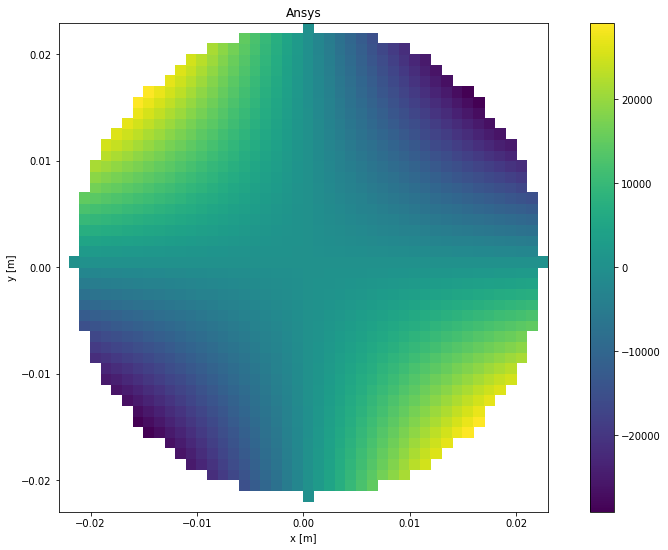

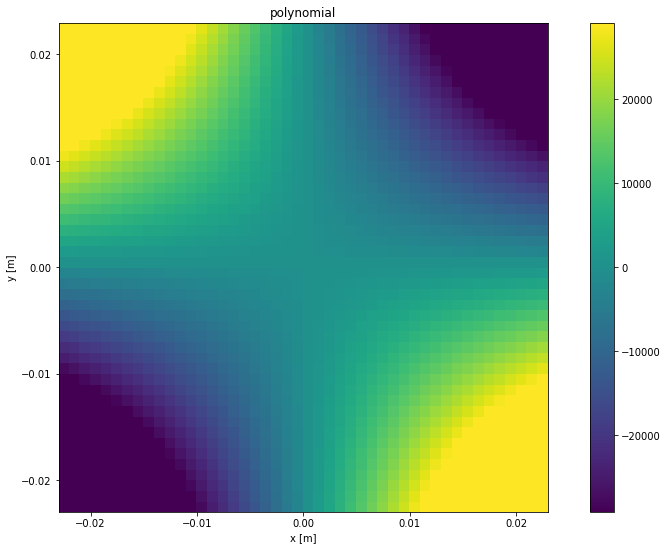

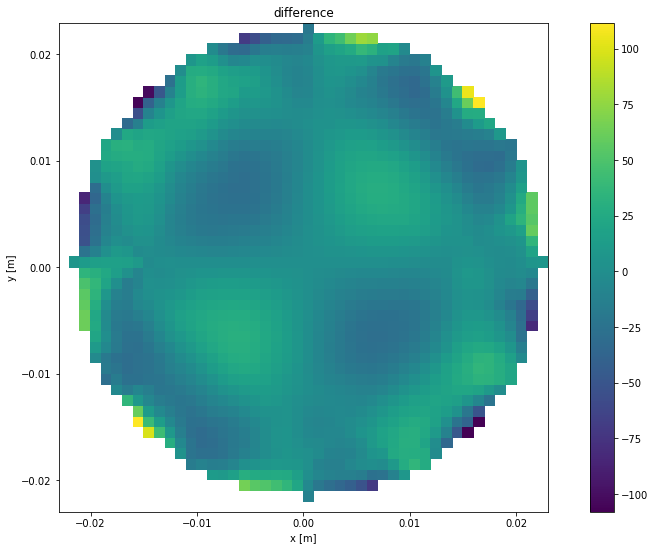

In [77]:
plot_slice(x_vals,y_vals,z_vals,pot_vals, c, 50)

Plotting the potential along z (quadrupole lens axis) for various points in the x,y plane

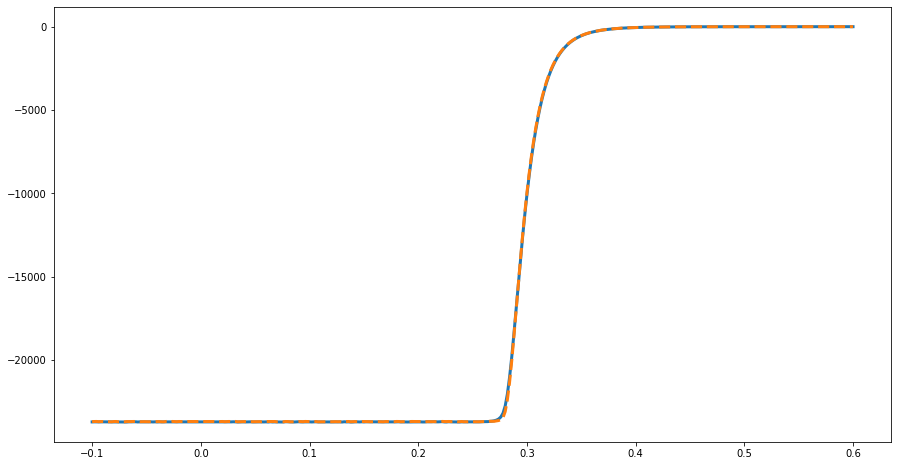

In [78]:
fmaskgrid = np.ones(len(z_vals), dtype = bool)
idx = find_nearest(x_vals, np.sqrt(0.0199**2/2))
idy = find_nearest(y_vals, np.sqrt(0.0199**2/2))
fig, ax = plt.subplots(figsize = (15,8))
ax.plot(z_vals, pot_vals[idx, idy, :].flatten(), lw = 3)
ax.plot(z_vals, intfun(z_vals)*polynomial.polyval2d(x_vals[idx], y_vals[idy], c), '--', lw = 3)

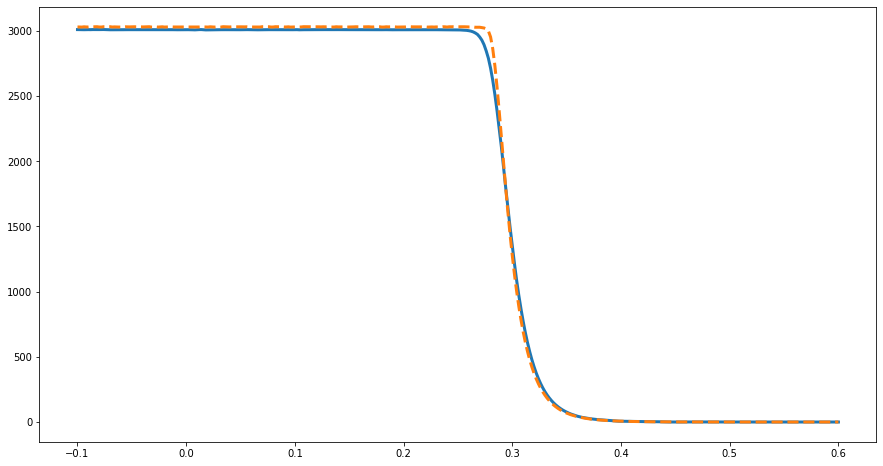

In [79]:
idx = find_nearest(x_vals, 0.005)
idy = find_nearest(y_vals, -0.005)
fig, ax = plt.subplots(figsize = (15,8))
ax.plot(z_vals, pot_vals[idx, idy, :].flatten(), lw = 3)
ax.plot(z_vals, intfun(z_vals)*polynomial.polyval2d(x_vals[idx], y_vals[idy], c), '--', lw = 3)

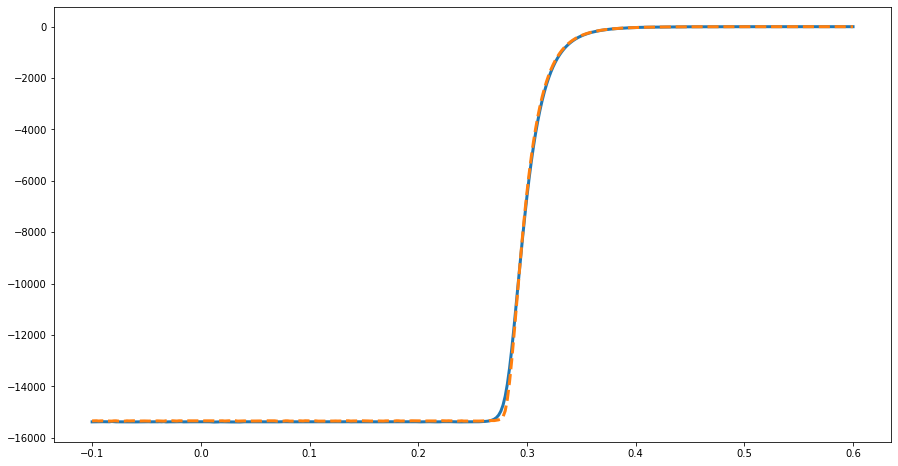

In [80]:
idx = find_nearest(x_vals, 0.008)
idy = find_nearest(y_vals, 0.016)
fig, ax = plt.subplots(figsize = (15,8))
ax.plot(z_vals, pot_vals[idx, idy, :].flatten(), lw = 3)
ax.plot(z_vals, intfun(z_vals)*polynomial.polyval2d(x_vals[idx], y_vals[idy], c), '--', lw = 3)

# Potential Plates

Repeating the same function generation for the potential plates

In [81]:
rfp = open('potentialElectrodes_offset_1kV.fld', 'r')
tmp = rfp.read()
tmp = tmp.split('\n')[2:-1]
tmp = [[float(tis) for tis in ti.split()] for ti in tmp]

xP = np.array([row[0] for row in tmp])
yP = np.array([row[1] for row in tmp])
zP = np.array([row[2] for row in tmp])
VP = np.array([row[3] for row in tmp])

Masking all values at $r>2.2$cm with `nan` in the potential

In [82]:
mask = (np.sqrt(xP**2+yP**2) > 0.022)
VP[mask] = np.nan

(xP_vals, yP_vals, zP_vals), potP_vals = create_grid_potential(xP,yP,zP,VP)

In [83]:
maskz = np.abs(zP[np.invert(mask)] - 0.45) < 1e-4
cP = polyfit2d(xP[np.invert(mask)][maskz], yP[np.invert(mask)][maskz], VP[np.invert(mask)][maskz], [5,5])

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  if sys.path[0] == '':


Plotting a slice of the xy plane at $z = 0.45$ (middle of the homogeneous field, where the simulation ends)

0.45000000000000007


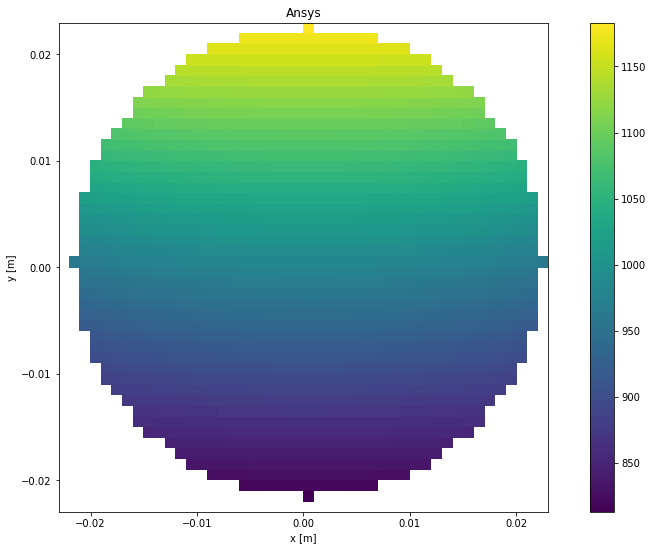

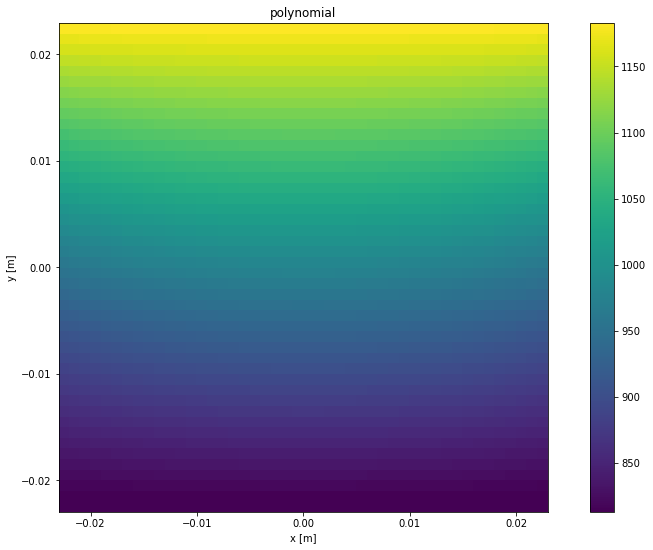

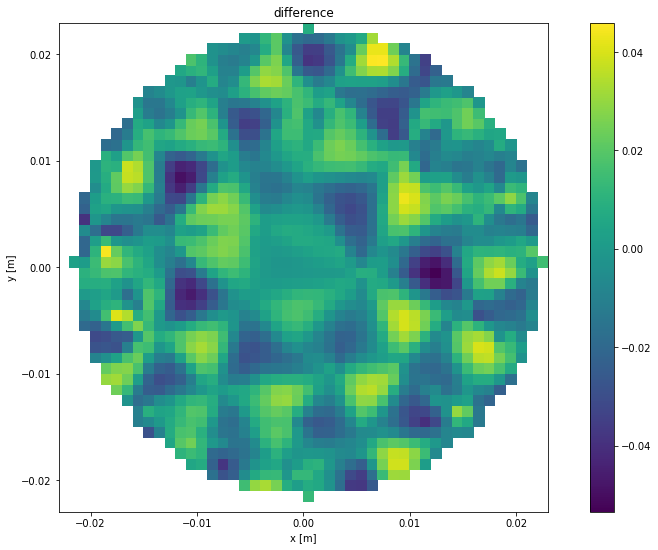

In [84]:
plot_slice(xP_vals, yP_vals, zP_vals, potP_vals, cP, 275)

Plotting the potential along the z axis at $r = 0$ m

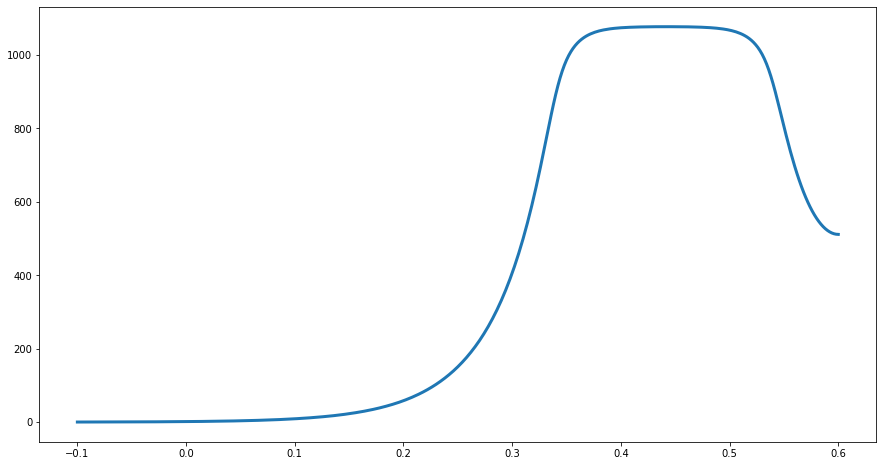

In [90]:
idx = find_nearest(xP_vals, np.sqrt(0.016**2/2))
idy = find_nearest(yP_vals, np.sqrt(0.016**2/2))
fig, ax = plt.subplots(figsize = (15,8))
ax.plot(zP_vals, potP_vals[idx, idy, :].flatten(), lw = 3)

Generating the `UnivariateSplice` to interpolate the potential along the z axis, need to wrap around zero because the homogeneous field is at $z=-0.45m$ and $z=0.45m$

In [91]:
maskzP = zP_vals > 0
f = np.abs(potP_vals[idx, idy, :].flatten())[maskzP]
f -= f.min()
f /= f.max()

lP = maskzP.sum()
zP_spliced = np.zeros(lP*2+1)
ind_sort = np.argsort(-zP_vals[maskzP])
zP_spliced[:lP] = -zP_vals[maskzP][ind_sort]
zP_spliced[-lP:] = zP_vals[maskzP]
f_spliced = np.zeros(lP*2+1)
f_spliced[:lP] = f[ind_sort]
f_spliced[-lP:] = f

from scipy.interpolate import interp1d, UnivariateSpline
intfunP = UnivariateSpline(zP_spliced, f_spliced, s = 0)

Figure shows the potential along z plotted over the potential from Ansys

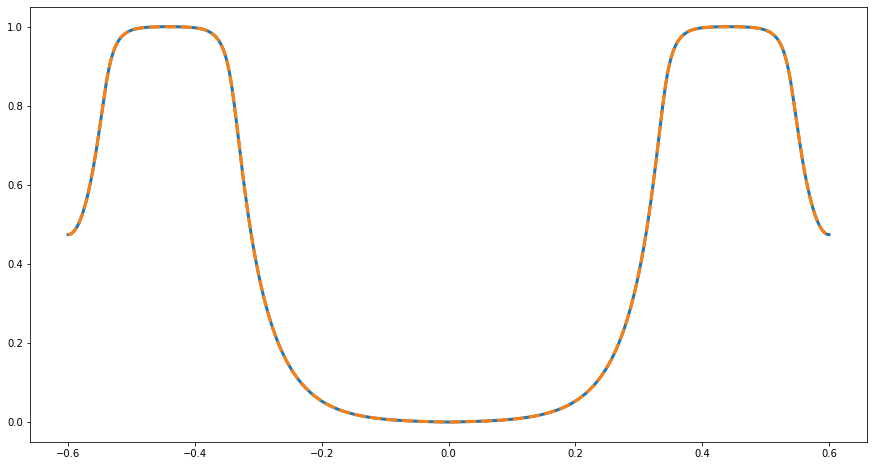

In [92]:
fig, ax = plt.subplots(figsize = (15,8))
ax.plot(zP_spliced, f_spliced, lw = 3)
ax.plot(zP_spliced, intfunP(zP_spliced), '--', lw = 3)

Figure combines the 2D potential from the xy plane with the `UnivariateSplice` potential along z

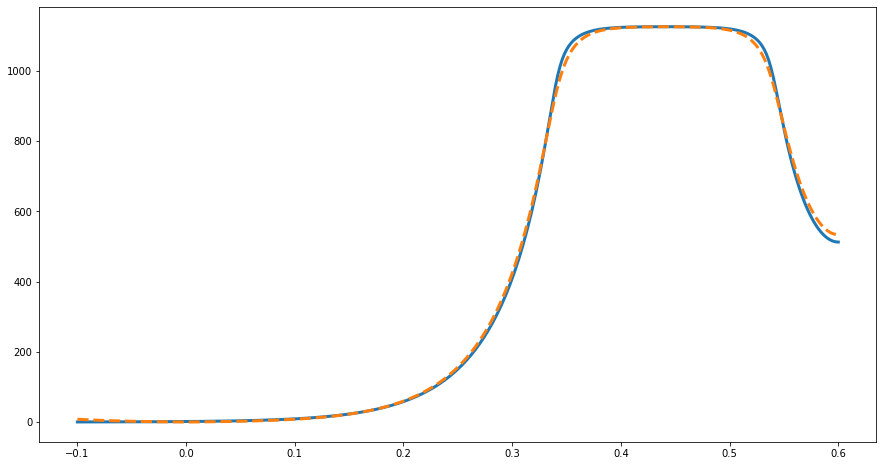

In [93]:
idx = find_nearest(xP_vals, 0.008)
idy = find_nearest(yP_vals, 0.016)
fig, ax = plt.subplots(figsize = (15,8))
ax.plot(zP_vals, potP_vals[idx, idy, :].flatten(), lw = 3)
ax.plot(zP_vals, intfunP(zP_vals)*polynomial.polyval2d(xP_vals[idx], yP_vals[idy], cP), '--', lw = 3)

Function to plot the field at a certain z index, can only plot $E_x$ or $E_y$ (axis = 0 or axis = 1)

In [94]:
def plot_field(x_vals, y_vals, z_vals, c, intfun, idz, axis = 0):
    print(f'z = {z_vals[idz]:.2f}')
    z = z_vals[idz]
    X,Y = np.meshgrid(x_vals, y_vals)

    cder = polynomial.polyder(c, axis = axis)
    fig, ax = plt.subplots(figsize = (15,9))
    if axis == 0 or axis == 1:
        cax = ax.pcolormesh(X,Y,-intfun(z)*polynomial.polyval2d(X, Y, cder))
        ax.set_xlabel('x [m]')
        ax.set_ylabel('y [m]')
    if axis == 0:
        ax.set_title('Ex')
    elif axis == 1: 
        ax.set_title('Ey')
    elif axis == 2:
        ax.set_title('Ez')
    cbar = fig.colorbar(cax)
    ax.set_aspect(y.ptp()/x.ptp())

z = 0.45
z = 0.45


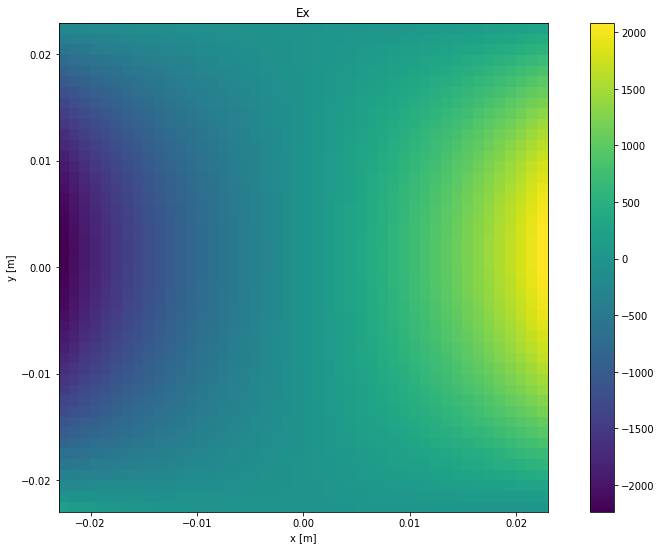

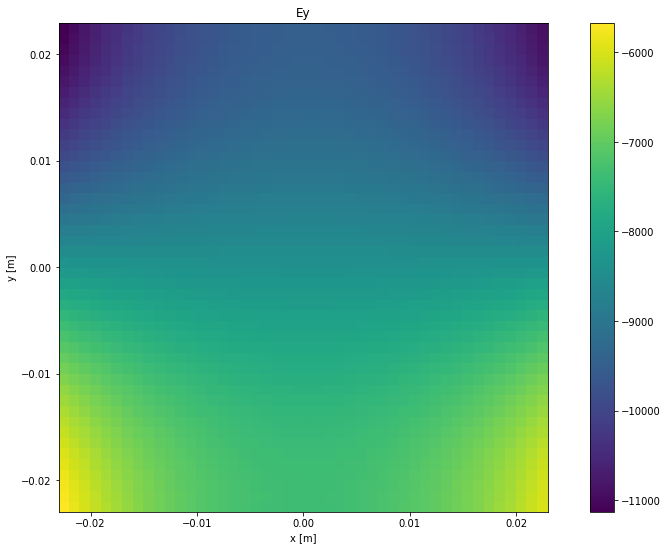

In [95]:
plot_field(xP_vals, yP_vals, zP_vals, cP, intfunP, 275, axis = 0)
plot_field(xP_vals, yP_vals, zP_vals, cP, intfunP, 275, axis = 1)

# Combining Potentials

Plotting the potential of the Quadrupole and the homogeneous field at $r = 1.9$cm

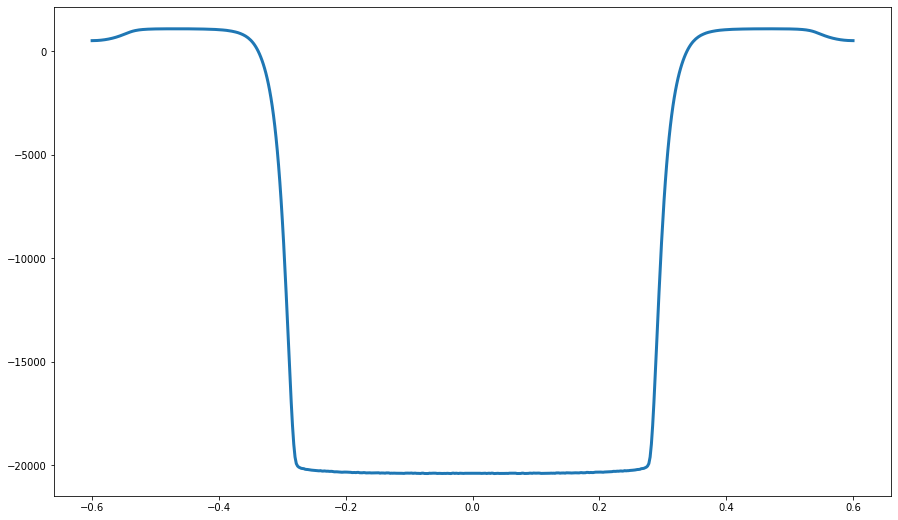

In [96]:
idx = find_nearest(xP_vals, np.sqrt(0.019**2/2))
idy = find_nearest(yP_vals, np.sqrt(0.019**2/2))
xi = xP_vals[idx]
yi = yP_vals[idx]

fig, ax = plt.subplots(figsize = (15,9))
ax.plot(zP_spliced, intfunP(zP_spliced)*polynomial.polyval2d(xi,yi,cP)+intfun(zP_spliced)*polynomial.polyval2d(xi,yi,c), lw = 3)

Taking the derivatives of the interpolating functions to get the electric fields

In [97]:
x_cder = polynomial.polyder(c, axis = 0)
x_cPder = polynomial.polyder(cP, axis = 0)
y_cder = polynomial.polyder(c, axis = 1)
y_cPder = polynomial.polyder(cP, axis = 1)

Ex_tot = lambda x,y,z: intfunP(z)*polynomial.polyval2d(x,y,x_cPder)+intfun(z)*polynomial.polyval2d(x,y,x_cder)
Ey_tot = lambda x,y,z: intfunP(z)*polynomial.polyval2d(x,y,y_cPder)+intfun(z)*polynomial.polyval2d(x,y,y_cder)
Ez_tot = lambda x,y,z: intfunP.derivative()(z)*polynomial.polyval2d(x,y,cP)+intfun.derivative()(z)*polynomial.polyval2d(x,y,c)
Etot = lambda x,y,z: np.sqrt(Ex_tot(x,y,z)**2+Ey_tot(x,y,z)**2+Ez_tot(x,y,z)**2)

Plotting the fields at $r=1.6$cm

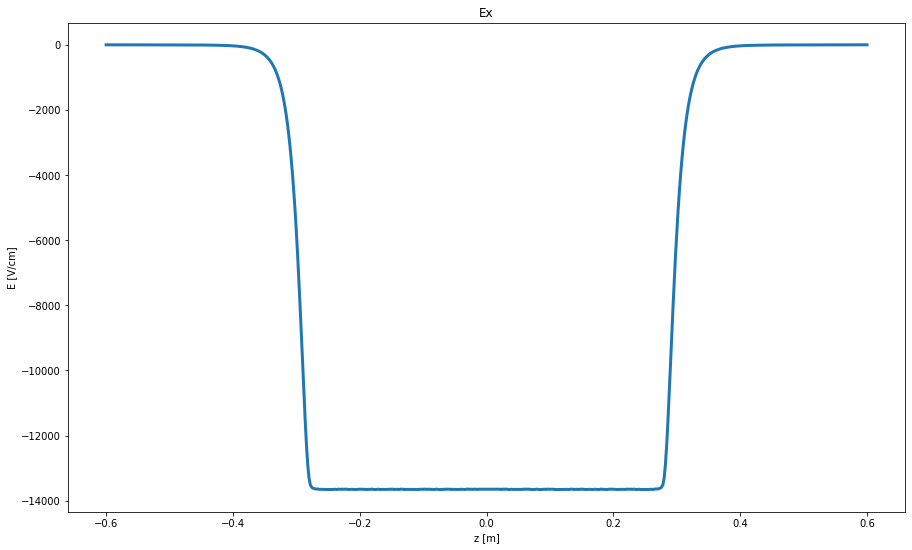

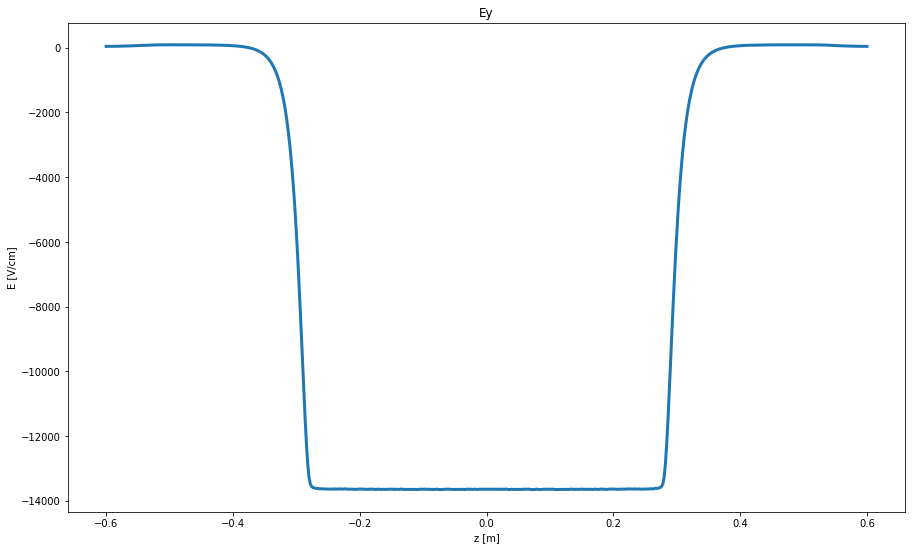

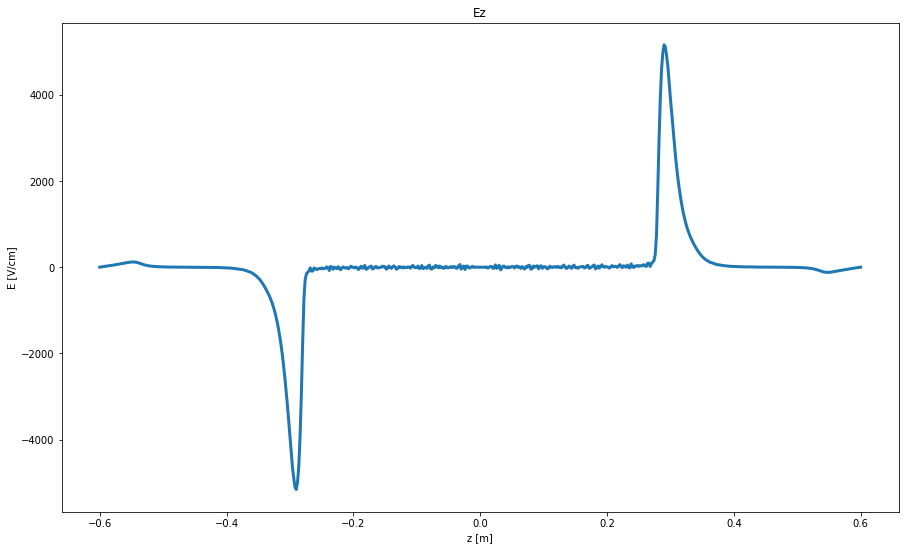

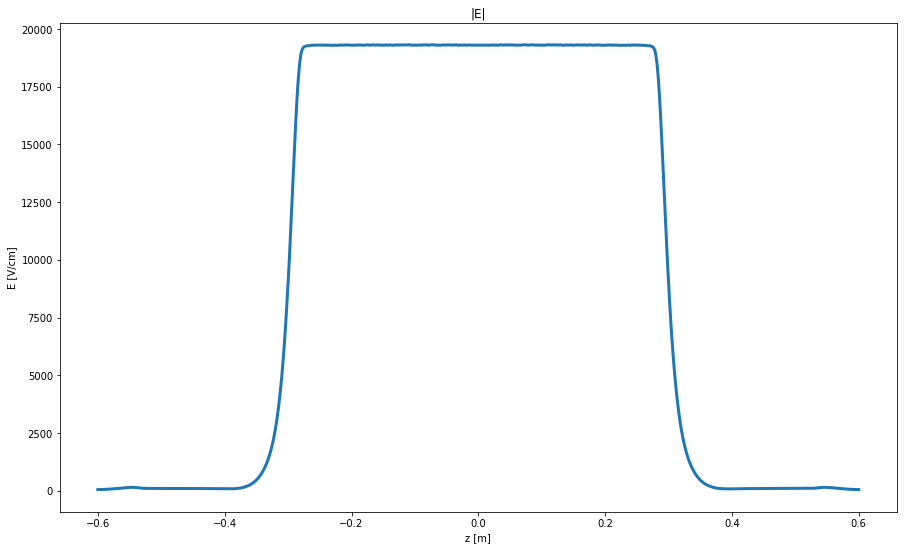

In [111]:
xi = np.sqrt(0.016**2/2)
yi = np.sqrt(0.016**2/2)

fig, ax = plt.subplots(figsize = (15,9))
ax.plot(zP_spliced, Ex_tot(xi,yi,zP_spliced)*1e-2, lw = 3)
ax.set_xlabel('z [m]')
ax.set_ylabel('E [V/cm]')
ax.set_title('Ex')

fig, ax = plt.subplots(figsize = (15,9))
ax.plot(zP_spliced, Ey_tot(xi,yi,zP_spliced)*1e-2, lw = 3)
ax.set_xlabel('z [m]')
ax.set_ylabel('E [V/cm]')
ax.set_title('Ey')

fig, ax = plt.subplots(figsize = (15,9))
ax.plot(zP_spliced, Ez_tot(xi,yi,zP_spliced)*1e-2, lw = 3)
ax.set_xlabel('z [m]')
ax.set_ylabel('E [V/cm]')
ax.set_title('Ez')

fig, ax = plt.subplots(figsize = (15,9))
ax.plot(zP_spliced, Etot(xi,yi,zP_spliced)*1e-2, lw = 3)
ax.set_xlabel('z [m]')
ax.set_ylabel('E [V/cm]')
ax.set_title('|E|');

Plotting the fields at $r=0$ cm

Text(0.5, 1.0, '|E|')

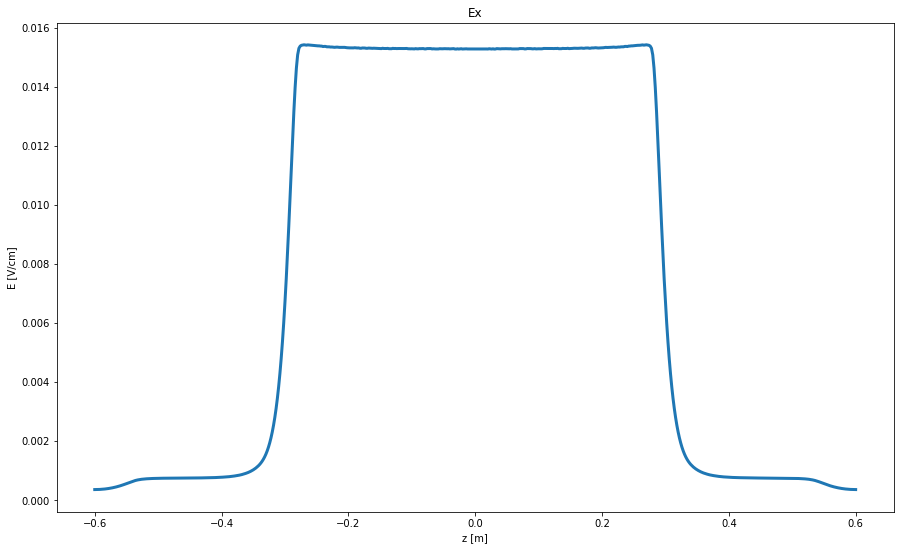

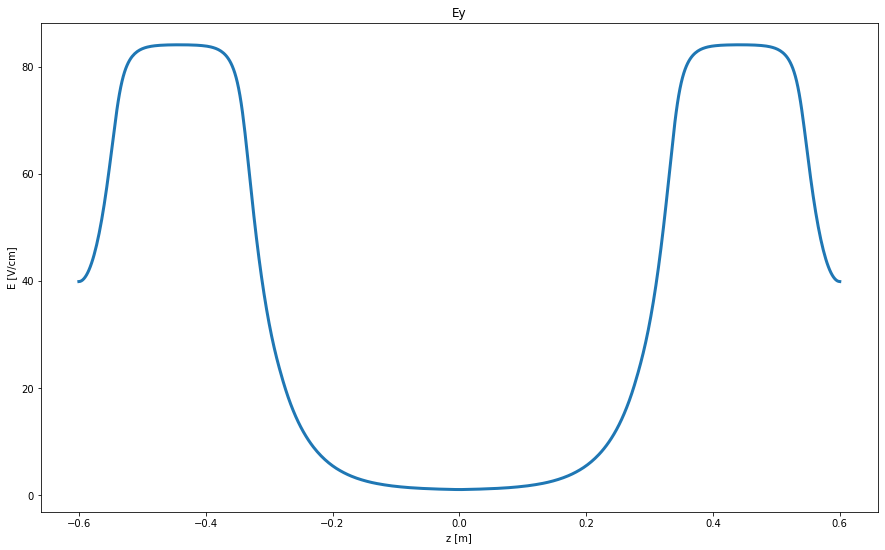

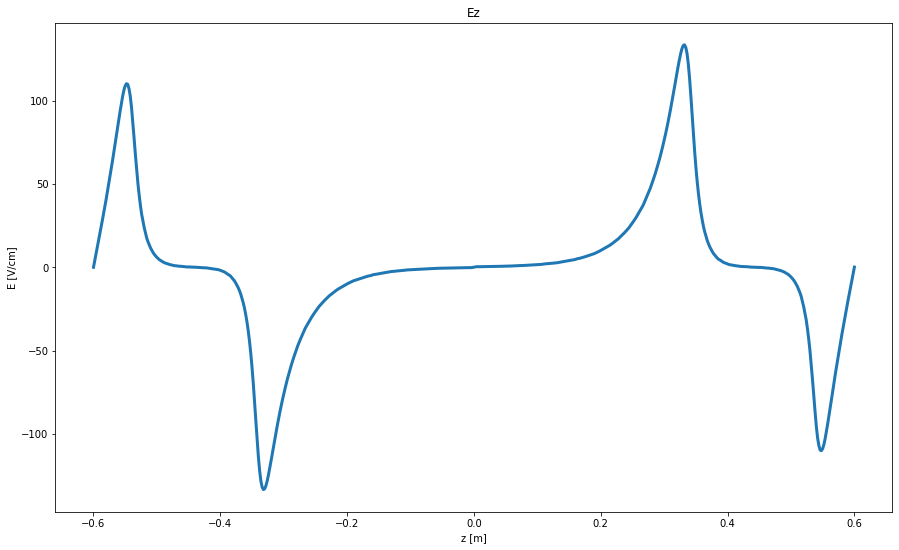

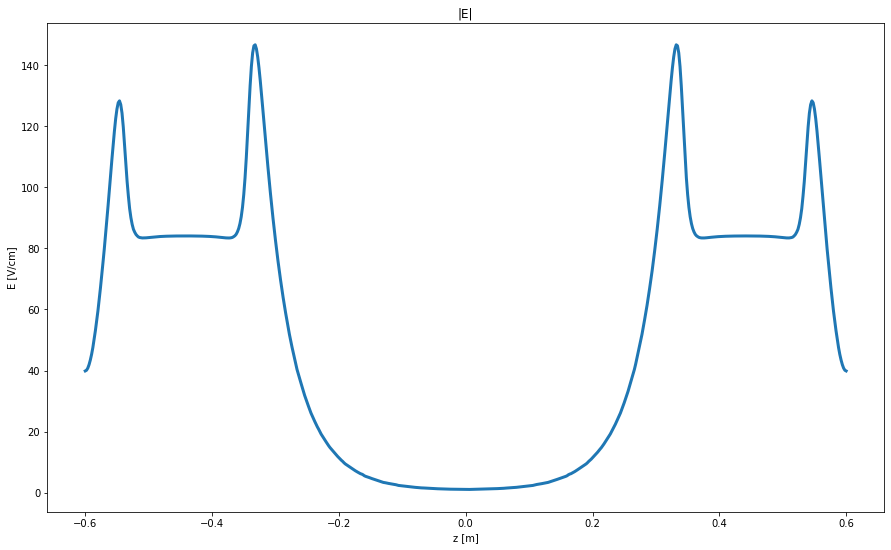

In [110]:
xi = np.sqrt(0**2/2)
yi = np.sqrt(0**2/2)

fig, ax = plt.subplots(figsize = (15,9))
ax.plot(zP_spliced, Ex_tot(xi,yi,zP_spliced)*1e-2, lw = 3)
ax.set_xlabel('z [m]')
ax.set_ylabel('E [V/cm]')
ax.set_title('Ex')

fig, ax = plt.subplots(figsize = (15,9))
ax.plot(zP_spliced, Ey_tot(xi,yi,zP_spliced)*1e-2, lw = 3)
ax.set_xlabel('z [m]')
ax.set_ylabel('E [V/cm]')
ax.set_title('Ey')

fig, ax = plt.subplots(figsize = (15,9))
ax.plot(zP_spliced, Ez_tot(xi,yi,zP_spliced)*1e-2, lw = 3)
ax.set_xlabel('z [m]')
ax.set_ylabel('E [V/cm]')
ax.set_title('Ez')

fig, ax = plt.subplots(figsize = (15,9))
ax.plot(zP_spliced, Etot(xi,yi,zP_spliced)*1e-2, lw = 3)
ax.set_xlabel('z [m]')
ax.set_ylabel('E [V/cm]')
ax.set_title('|E|')

worst trajectory from simulations

Text(0.5, 1.0, '|E|')

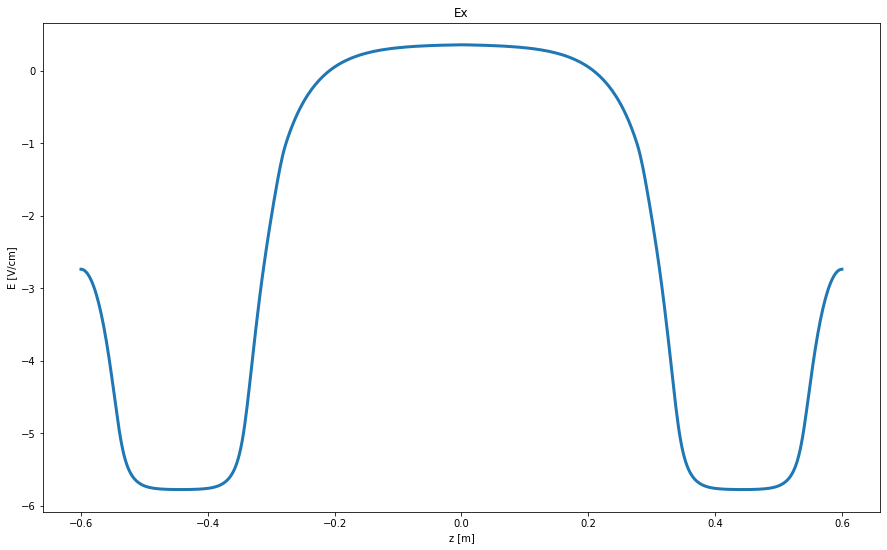

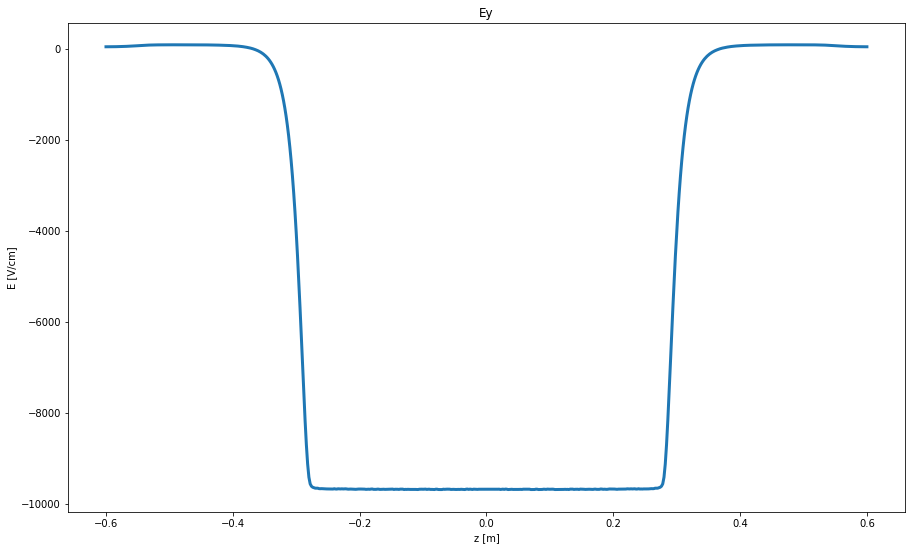

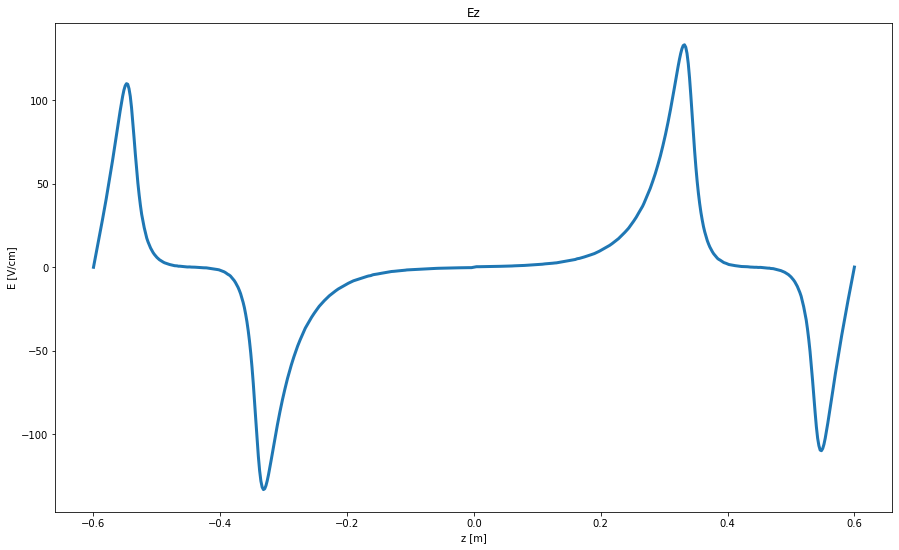

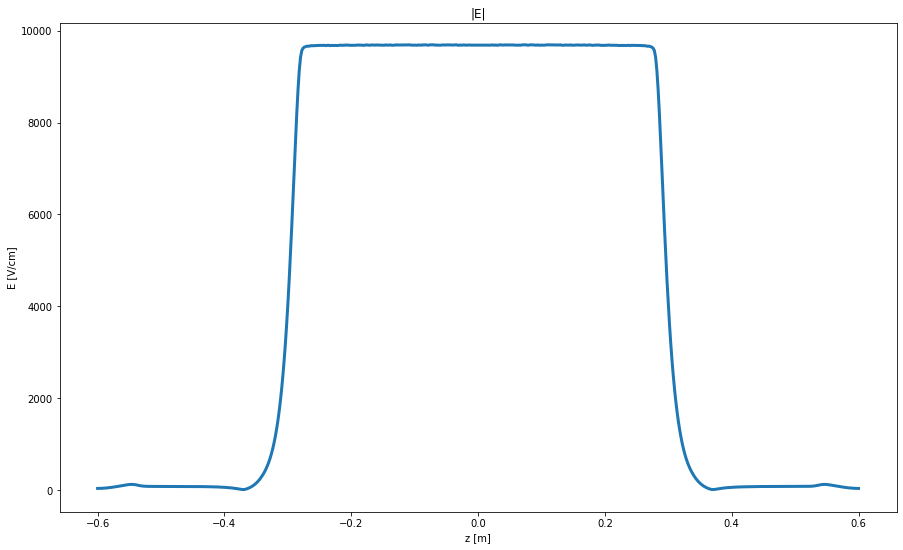

In [108]:
xi = 0.008
yi = 0

fig, ax = plt.subplots(figsize = (15,9))
ax.plot(zP_spliced, Ex_tot(xi,yi,zP_spliced)*1e-2, lw = 3)
ax.set_xlabel('z [m]')
ax.set_ylabel('E [V/cm]')
ax.set_title('Ex')

fig, ax = plt.subplots(figsize = (15,9))
ax.plot(zP_spliced, Ey_tot(xi,yi,zP_spliced)*1e-2, lw = 3)
ax.set_xlabel('z [m]')
ax.set_ylabel('E [V/cm]')
ax.set_title('Ey')

fig, ax = plt.subplots(figsize = (15,9))
ax.plot(zP_spliced, Ez_tot(xi,yi,zP_spliced)*1e-2, lw = 3)
ax.set_xlabel('z [m]')
ax.set_ylabel('E [V/cm]')
ax.set_title('Ez')

fig, ax = plt.subplots(figsize = (15,9))
ax.plot(zP_spliced, Etot(xi,yi,zP_spliced)*1e-2, lw = 3)
ax.set_xlabel('z [m]')
ax.set_ylabel('E [V/cm]')
ax.set_title('|E|')

Now checking the difference between a good (blue) and bad (orange) trajectory

Text(0.5, 1.0, '|E|')

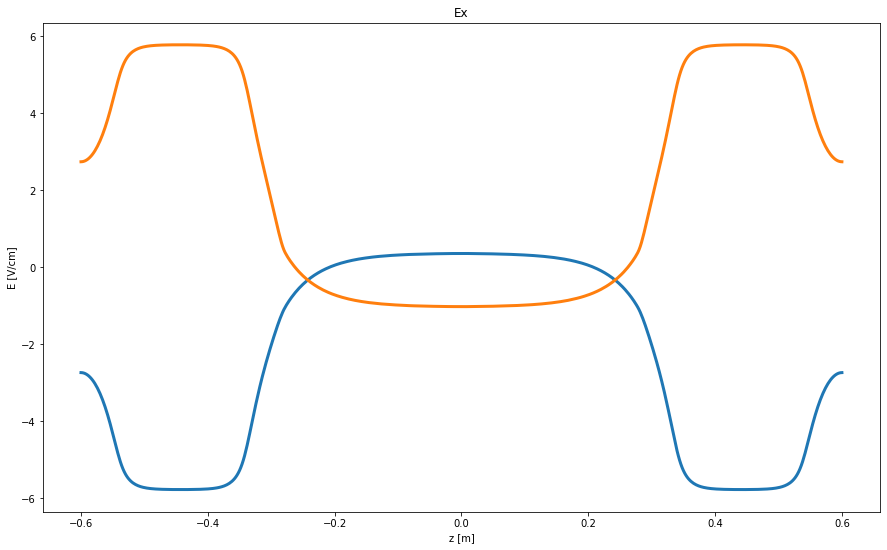

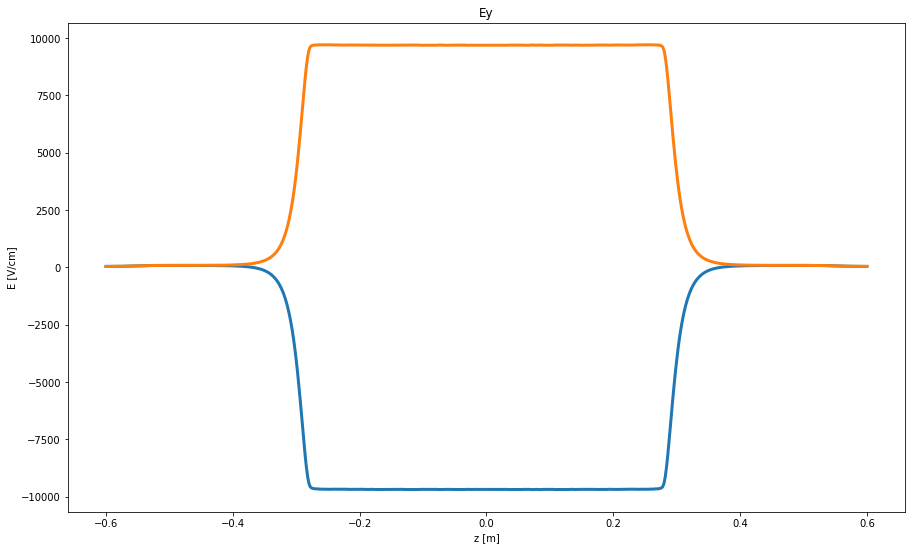

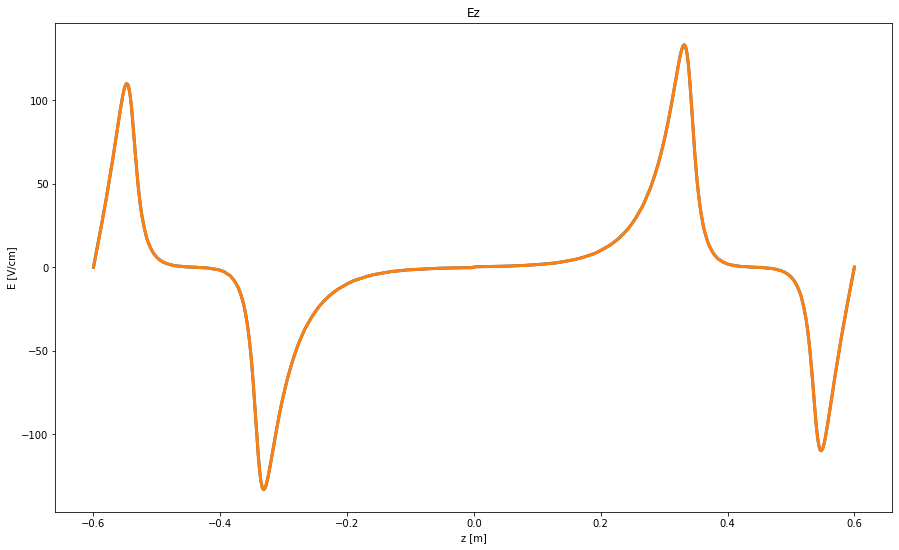

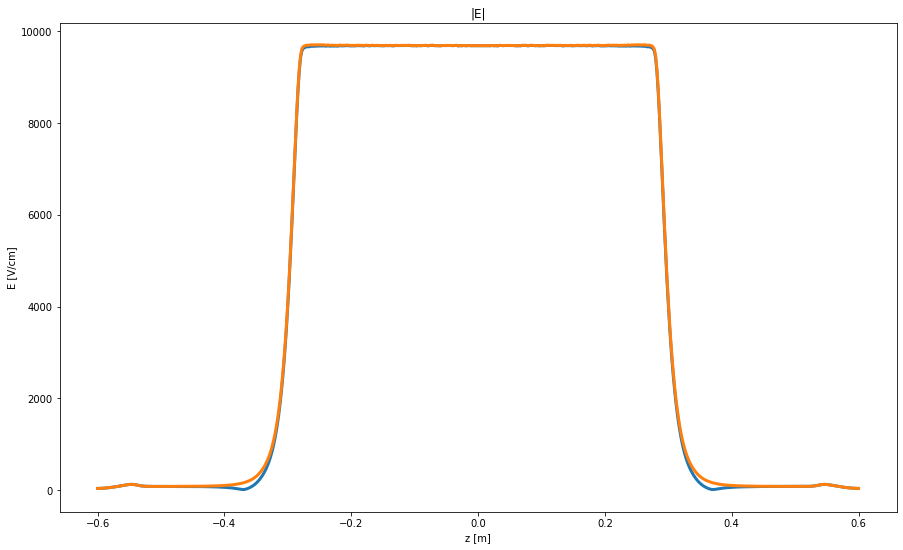

In [114]:
xi = 0.008
yi = 0
xi_op = -0.008
yi_op = 0

fig, ax = plt.subplots(figsize = (15,9))
ax.plot(zP_spliced, Ex_tot(xi,yi,zP_spliced)*1e-2, lw = 3)
ax.plot(zP_spliced, Ex_tot(xi_op,yi_op,zP_spliced)*1e-2, lw = 3)
ax.set_xlabel('z [m]')
ax.set_ylabel('E [V/cm]')
ax.set_title('Ex')

fig, ax = plt.subplots(figsize = (15,9))
ax.plot(zP_spliced, Ey_tot(xi,yi,zP_spliced)*1e-2, lw = 3)
ax.plot(zP_spliced, Ey_tot(xi_op,yi_op,zP_spliced)*1e-2, lw = 3)
ax.set_xlabel('z [m]')
ax.set_ylabel('E [V/cm]')
ax.set_title('Ey')

fig, ax = plt.subplots(figsize = (15,9))
ax.plot(zP_spliced, Ez_tot(xi,yi,zP_spliced)*1e-2, lw = 3)
ax.plot(zP_spliced, Ez_tot(xi_op,yi_op,zP_spliced)*1e-2, lw = 3)
ax.set_xlabel('z [m]')
ax.set_ylabel('E [V/cm]')
ax.set_title('Ez')

fig, ax = plt.subplots(figsize = (15,9))
ax.plot(zP_spliced, Etot(xi,yi,zP_spliced)*1e-2, lw = 3)
ax.plot(zP_spliced, Etot(xi_op,yi_op,zP_spliced)*1e-2, lw = 3)
ax.set_xlabel('z [m]')
ax.set_ylabel('E [V/cm]')
ax.set_title('|E|')

Only difference of note occurs in y, as expected, good trajectory just increases in field, whereas the bad trajectory has a dip in the field, crossing the avoided crossing

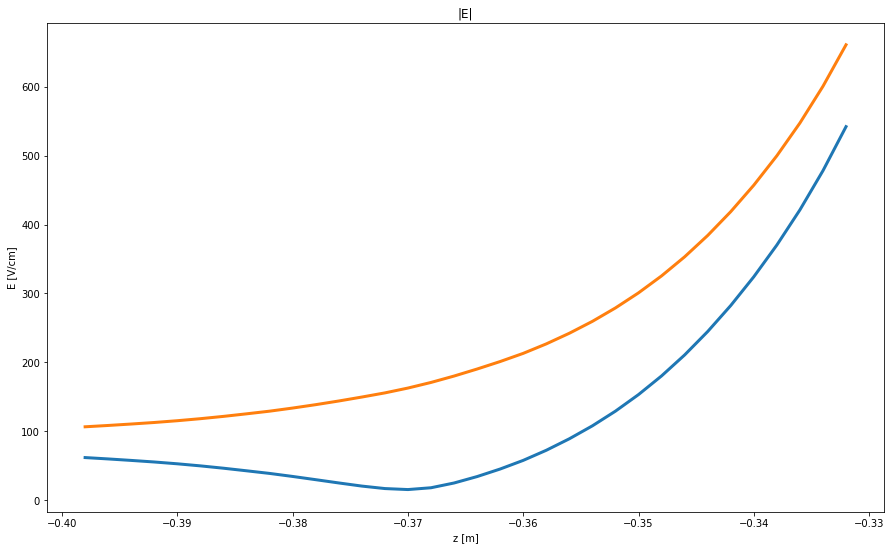

In [119]:
mask = (zP_spliced > -0.4) & (zP_spliced < -0.33)

fig, ax = plt.subplots(figsize = (15,9))
ax.plot(zP_spliced[mask], Etot(xi,yi,zP_spliced)[mask]*1e-2, lw = 3)
ax.plot(zP_spliced[mask], Etot(xi_op,yi_op,zP_spliced)[mask]*1e-2, lw = 3)
ax.set_xlabel('z [m]')
ax.set_ylabel('E [V/cm]')
ax.set_title('|E|');